In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
from typing import List
import warnings
warnings.filterwarnings('ignore')

In [10]:
class TimeSeriesDataset(Dataset):
    """Dataset class for time series speed data"""
    
    def __init__(self, data: np.ndarray, labels: np.ndarray, sequence_length: int = 50):
        self.data = data
        self.labels = labels
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length + 1
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.sequence_length]
        y = self.labels[idx:idx + self.sequence_length]
        return torch.FloatTensor(x), torch.FloatTensor(y)

In [ ]:
class MultiBottleneckVAE(nn.Module):
    """
    Modified VAE with multiple bottlenecks of different sizes
    """
    
    def __init__(self, input_dim: int, hidden_dims: List[int], 
                 bottleneck_dims: List[int], sequence_length: int = 50):
        super(MultiBottleneckVAE, self).__init__()
        
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.bottleneck_dims = bottleneck_dims
        self.num_bottlenecks = len(bottleneck_dims)

        encoder_layers = []
        prev_dim = input_dim * sequence_length
        
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
            
        self.shared_encoder = nn.Sequential(*encoder_layers)

        self.mu_layers = nn.ModuleList()
        self.logvar_layers = nn.ModuleList()
        
        for bottleneck_dim in bottleneck_dims:
            self.mu_layers.append(nn.Linear(prev_dim, bottleneck_dim))
            self.logvar_layers.append(nn.Linear(prev_dim, bottleneck_dim))

        self.decoders = nn.ModuleList()
        
        for bottleneck_dim in bottleneck_dims:
            decoder_layers = []
            decoder_prev_dim = bottleneck_dim

            for hidden_dim in reversed(hidden_dims):
                decoder_layers.extend([
                    nn.Linear(decoder_prev_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Dropout(0.2)
                ])
                decoder_prev_dim = hidden_dim

            decoder_layers.append(nn.Linear(decoder_prev_dim, input_dim * sequence_length))
            
            self.decoders.append(nn.Sequential(*decoder_layers))
    
    def encode(self, x):
        """Encode input to multiple latent representations"""
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)

        encoded = self.shared_encoder(x_flat)

        mus = []
        logvars = []
        
        for i in range(self.num_bottlenecks):
            mu = self.mu_layers[i](encoded)
            logvar = self.logvar_layers[i](encoded)
            mus.append(mu)
            logvars.append(logvar)
            
        return mus, logvars
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, zs):
        """Decode from multiple latent representations"""
        reconstructions = []
        
        for i, z in enumerate(zs):
            recon = self.decoders[i](z)
            recon = recon.view(-1, self.sequence_length, self.input_dim)
            reconstructions.append(recon)
            
        return reconstructions
    
    def forward(self, x):
        """Forward pass through the multi-bottleneck VAE"""
        mus, logvars = self.encode(x)

        zs = []
        for mu, logvar in zip(mus, logvars):
            z = self.reparameterize(mu, logvar)
            zs.append(z)

        reconstructions = self.decode(zs)
        
        return reconstructions, mus, logvars

In [ ]:
def vae_loss_function(reconstructions, x, mus, logvars, beta=1.0):
    """
    VAE loss function combining reconstruction loss and KL divergence
    for multiple bottlenecks
    """
    batch_size = x.size(0)

    recon_losses = []
    for recon in reconstructions:
        recon_loss = F.mse_loss(recon, x, reduction='sum')
        recon_losses.append(recon_loss)
    
    avg_recon_loss = sum(recon_losses) / len(recon_losses)

    kl_losses = []
    for mu, logvar in zip(mus, logvars):
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_losses.append(kl_loss)
    
    total_kl_loss = sum(kl_losses)
    
    total_loss = avg_recon_loss + beta * total_kl_loss
    
    return total_loss, avg_recon_loss, total_kl_loss

In [ ]:
def compute_anomaly_scores(model, data_loader, device):
    """
    Compute anomaly scores using average reconstruction error
    from all bottlenecks
    """
    model.eval()
    anomaly_scores = []
    true_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)

            reconstructions, _, _ = model(batch_x)

            recon_errors = []
            for recon in reconstructions:
                error = torch.mean((batch_x - recon) ** 2, dim=(1, 2))
                recon_errors.append(error)

            avg_recon_error = torch.stack(recon_errors).mean(dim=0)
            
            anomaly_scores.extend(avg_recon_error.cpu().numpy())
            true_labels.extend(batch_y.cpu().numpy().max(axis=1))
    
    return np.array(anomaly_scores), np.array(true_labels)

In [ ]:
def train_multi_bottleneck_vae(model, train_loader, val_loader, device, 
                              epochs=100, lr=1e-3, beta=1.0):
    """
    Train the multi-bottleneck VAE
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch_x, _ in train_loader:
            batch_x = batch_x.to(device)
            
            optimizer.zero_grad()
            
            reconstructions, mus, logvars = model(batch_x)
            loss, recon_loss, kl_loss = vae_loss_function(
                reconstructions, batch_x, mus, logvars, beta
            )
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, _ in val_loader:
                batch_x = batch_x.to(device)
                
                reconstructions, mus, logvars = model(batch_x)
                loss, _, _ = vae_loss_function(
                    reconstructions, batch_x, mus, logvars, beta
                )
                val_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        
        scheduler.step(val_losses[-1])
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, '
                  f'Val Loss = {val_losses[-1]:.4f}')
    
    return train_losses, val_losses

In [ ]:
def prepare_data(df, sequence_length=50, test_split=0.2):
    """
    Prepare time series data for training
    """
    speed_data = df['speed'].values.reshape(-1, 1)
    labels = df['pred_label'].values

    scaler = StandardScaler()
    speed_normalized = scaler.fit_transform(speed_data)

    split_idx = int(len(speed_normalized) * (1 - test_split))
    
    train_data = speed_normalized[:split_idx]
    train_labels = labels[:split_idx]
    
    test_data = speed_normalized[split_idx:]
    test_labels = labels[split_idx:]

    train_dataset = TimeSeriesDataset(train_data, train_labels, sequence_length)
    test_dataset = TimeSeriesDataset(test_data, test_labels, sequence_length)
    
    return train_dataset, test_dataset, scaler

In [ ]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    df = pd.read_csv('AGC_Data.csv', usecols = ['speed', 'pred_label'])
    labels = df['pred_label'].values
    
    print("Data shape:", df.shape)
    print("Anomaly ratio:", labels.mean())

    sequence_length = 60
    train_dataset, test_dataset, scaler = prepare_data(df, sequence_length)

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_dim = 1
    hidden_dims = [256, 128, 64, 32]
    bottleneck_dims = [16, 8, 4, 2]

    model = MultiBottleneckVAE(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        bottleneck_dims=bottleneck_dims,
        sequence_length=sequence_length
    ).to(device)
    
    print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
    print(f"Bottleneck dimensions: {bottleneck_dims}")

    print("\nStarting training...")
    train_losses, val_losses = train_multi_bottleneck_vae(
        model, train_loader, test_loader, device, 
        epochs=100, lr=1e-4, beta=1.0
    )

    print("\nComputing anomaly scores...")
    anomaly_scores, true_labels = compute_anomaly_scores(model, test_loader, device)

    auc_score = roc_auc_score(true_labels, anomaly_scores)
    print(f"\nAUC Score: {auc_score:.4f}")

    threshold = np.percentile(anomaly_scores, 80)
    predicted_labels = (anomaly_scores > threshold).astype(int)
    
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(anomaly_scores[:1000])
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Anomaly Scores (First 1000 points)')
    plt.xlabel('Time Steps')
    plt.ylabel('Anomaly Score')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.hist(anomaly_scores[true_labels == 0], bins=50, alpha=0.7, label='Normal', density=True)
    plt.hist(anomaly_scores[true_labels == 1], bins=50, alpha=0.7, label='Anomaly', density=True)
    plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Anomaly Score Distribution')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Density')
    plt.legend()

    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(true_labels, anomaly_scores)
    
    plt.subplot(2, 2, 4)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, scaler, threshold

In [ ]:
def predict_anomalies(model, new_data, scaler, threshold, sequence_length=60, device='cpu'):
    model.eval()

    new_data_normalized = scaler.transform(new_data.reshape(-1, 1)).flatten()
    
    anomaly_scores = []
    
    with torch.no_grad():
        for i in range(len(new_data_normalized) - sequence_length + 1):
            sequence = new_data_normalized[i:i + sequence_length]
            x = torch.FloatTensor(sequence).unsqueeze(0).unsqueeze(-1).to(device)

            reconstructions, _, _ = model(x)

            recon_errors = []
            for recon in reconstructions:
                error = torch.mean((x - recon) ** 2)
                recon_errors.append(error)

            avg_recon_error = torch.stack(recon_errors).mean()
            anomaly_scores.append(avg_recon_error.cpu().item())
    
    anomaly_scores = np.array(anomaly_scores)
    predictions = (anomaly_scores > threshold).astype(int)
    
    return anomaly_scores, predictions

Using device: cpu
Data shape: (100000, 2)
Anomaly ratio: 0.04305
Model initialized with 297420 parameters
Bottleneck dimensions: [16, 8, 4, 2]

Starting training...
Epoch 0: Train Loss = 2756.9430, Val Loss = 1938.0060
Epoch 10: Train Loss = 1747.1161, Val Loss = 1656.3742
Epoch 20: Train Loss = 1722.0636, Val Loss = 1628.0248
Epoch 30: Train Loss = 1650.3729, Val Loss = 1629.3926
Epoch 40: Train Loss = 1586.4157, Val Loss = 1450.6043
Epoch 50: Train Loss = 1567.7651, Val Loss = 1437.8649
Epoch 60: Train Loss = 1556.6758, Val Loss = 1460.3686
Epoch 70: Train Loss = 1551.8752, Val Loss = 1444.7828
Epoch 80: Train Loss = 1549.0253, Val Loss = 1452.9502
Epoch 90: Train Loss = 1548.9938, Val Loss = 1453.7072

Computing anomaly scores...

AUC Score: 0.9900

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.81      0.90     19604
         1.0       0.08      0.99      0.15       337

    accuracy                           0.82     19

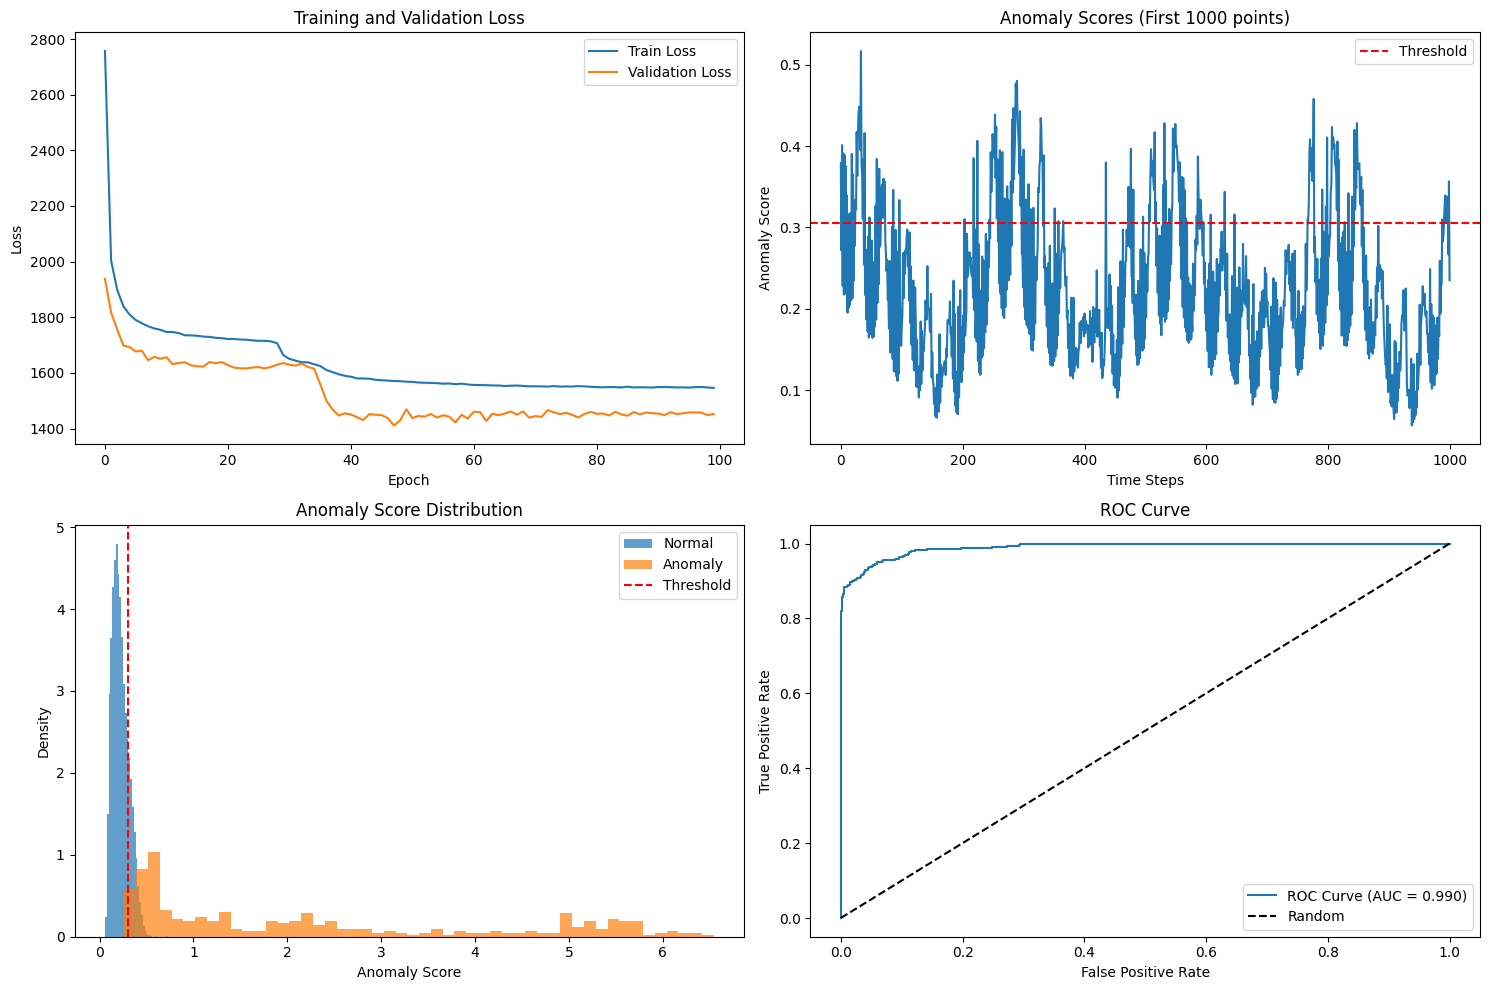

In [35]:
if __name__ == "__main__":
    model, scaler, threshold = main()

In [37]:
df = pd.read_csv("AGC_Data.csv", usecols=['speed', 'pred_label'])
predict_anomalies(model, df['speed'].iloc[100:180].to_numpy(), scaler, threshold, sequence_length=60, device='cpu')

(array([0.21129951, 0.13195339, 0.12091351, 0.21266472, 0.10485518,
        0.15037359, 0.09388325, 0.18246834, 0.07910735, 0.11234744,
        0.08836854, 0.13917972, 0.12392019, 0.1778408 , 0.15070239,
        0.25641423, 0.20444037, 0.24657291, 0.63070548, 0.31012607,
        0.2950722 ]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]))